In [1]:
import os
import pandas as pd
# from openai import OpenAI
# from dotenv import load_dotenv

In [2]:

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [4]:
df_review = pd.read_csv("C:/Users/delyr/Documents/GitHub/PSD/Dataset/IMDB Dataset.csv")
df_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
dfProcess = df_review["review"]
df_positive = dfProcess[df_review['sentiment']=='positive'][:500]
df_negative = dfProcess[df_review['sentiment']=='negative'][:500]

df_review_imb = pd.concat([df_positive,df_negative ])

df_review_imb.head()
df_review_imb.to_csv("USETHIS.csv")

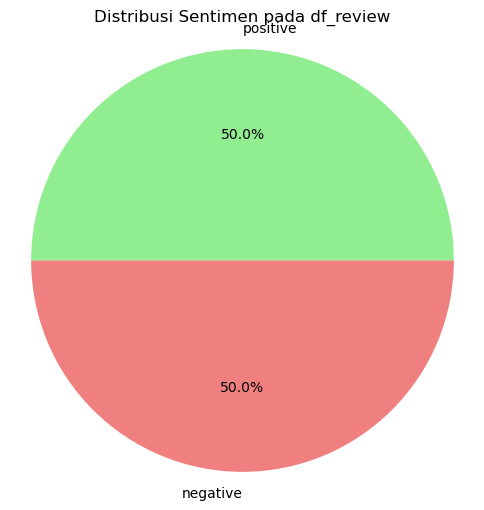

In [7]:
# Membuat pie chart untuk distribusi sentimen pada df_review
sentiment_counts = df_review['sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Distribusi Sentimen pada df_review')
plt.axis('equal')
plt.show()

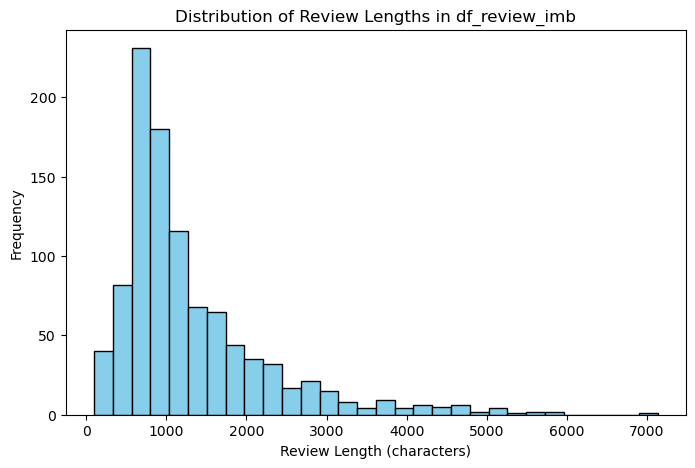

In [ ]:
import matplotlib.pyplot as plt

# Plot the length distribution of reviews in df_review_imb
review_lengths = df_review_imb.str.len()

plt.figure(figsize=(8, 5))
plt.hist(review_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths in df_review_imb')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [5]:
def analyze_sentiment(text):
    prompt = f"""
    Your role: As a sentiment analysis assistant that helps labeling message.
    Task: Answer with only one of the sentiment labels in the list (["negative", "positive"]) for the given message.
    STRICT RESTRICTION: You must answer only with either "positive" or "negative". 
    If uncertain, choose the most likely label based on the overall tone.
    Message: {text}
    """
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a strict sentiment classifier that only outputs 'positive' or 'negative'."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.0
    )
    
    # Extract and strictly validate the sentiment
    sentiment = response.choices[0].message.content.strip().lower()
    
    # Force binary classification
    if "positive" in sentiment:
        return "positive"
    elif "negative" in sentiment:
        return "negative"
    
    # Final fallback to positive for any ambiguous cases
    return "positive"

def process_csv_file(csv_path, output_path=None):
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
        
        # Check if the file has any data
        if df.empty:
            print("The CSV file is empty.")
            return
        
        # Ask user which column contains the text to analyze
        print("Available columns:")
        for i, col in enumerate(df.columns):
            print(f"{i+1}. {col}")
        
        col_index = int(input("Enter the number of the column containing text to analyze: ")) - 1
        text_column = df.columns[col_index]
        
        print(f"Analyzing sentiment for column: {text_column}")
        print("This may take some time depending on the number of rows...")
        
        # Add a new column for sentiment
        df['sentiment'] = df[text_column].apply(analyze_sentiment)
        
        # If no output path is specified, create one based on the input file
        if output_path is None:
            base_name = os.path.splitext(csv_path)[0]
            output_path = f"{base_name}_with_sentiment.csv"
        
        # Save the dataframe with sentiment analysis to a new CSV file
        df.to_csv(output_path, index=False)
        print(f"Sentiment analysis completed! Results saved to: {output_path}")
        
        # Print summary of results
        sentiment_counts = df['sentiment'].value_counts()
        print("\nSentiment Distribution:")
        for sentiment, count in sentiment_counts.items():
            print(f"{sentiment}: {count} ({count/len(df)*100:.1f}%)")
        
        return df
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [6]:
if __name__ == "__main__":
    # Get input file path from user
    csv_file_path = input("Enter the path to your CSV file: ")
    
    # Process the file
    result_df = process_csv_file(csv_file_path)

Available columns:
1. Unnamed: 0
2. review
Analyzing sentiment for column: review
This may take some time depending on the number of rows...


KeyboardInterrupt: 

In [ ]:
result_df.to_csv("results.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import openai
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Download necessary NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

def generate_wordcloud(text_series, title):
    """Generate a word cloud from a series of texts"""
    # Convert entire series to strings first
    text_series = text_series.astype(str)
    
    # Combine all text
    text = ' '.join(text_series)
    
    # Clean the text
    text = clean_text(text)
    
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Create and generate word cloud
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords=stop_words,
                         max_words=100).generate(text)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)
    plt.tight_layout(pad=0)
    
    return fig

def clean_text(text):
    """Clean text by removing HTML tags, special characters, and converting to lowercase"""
    # Ensure input is always treated as string
    text = str(text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_most_common_words(text_series, top_n=10):
    """Extract most common words from a series of texts"""
    # Clean and tokenize all texts
    all_words = []
    stop_words = set(stopwords.words('english'))
    
    for text in text_series:
        cleaned_text = clean_text(text)
        tokens = word_tokenize(cleaned_text)
        words = [word for word in tokens if word.isalpha() and word not in stop_words]
        all_words.extend(words)
    
    # Get most common words
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

def extract_top_tfidf_terms(text_series, top_n=10):
    """Extract most important terms using TF-IDF"""
    # Clean texts
    cleaned_texts = [clean_text(text) for text in text_series]
    
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts)
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Calculate average TF-IDF score for each term
    avg_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)
    
    # Get top terms
    top_indices = avg_tfidf.argsort()[-top_n:][::-1]
    top_terms = [(feature_names[idx], avg_tfidf[idx]) for idx in top_indices]
    
    return top_terms

def generate_ai_summary_for_category(analysis_data, category):
    """Generate an AI summary using OpenAI API based on the analysis data for a specific category"""
    try:
        # Set up OpenAI API client
        openai.api_key = os.getenv("OPENAI_API_KEY")
        
        # Create different prompts based on the category
        if category == "positive":
            prompt = f"""
            Based on the following analysis of POSITIVE customer reviews, generate a concise summary paragraph
            highlighting the key findings, patterns, and insights:

            Total Positive Reviews: {analysis_data['positive']} ({analysis_data['positive_pct']}%)
            
            Top terms in positive reviews (TF-IDF):
            {analysis_data['pos_terms']}

            Most common words in positive reviews:
            {analysis_data['pos_common']}
            
            Average length of positive reviews: {analysis_data['pos_avg_len']} characters
            
            Focus on what customers liked, product strengths, and positive aspects of the customer experience.
            """
            system_prompt = "You are an expert data analyst. Summarize the positive review findings into a concise, insight-driven paragraph that highlights patterns and key strengths mentioned in positive reviews."
        
        elif category == "negative":
            prompt = f"""
            Based on the following analysis of NEGATIVE customer reviews, generate a concise summary paragraph
            highlighting the key findings, patterns, and insights:

            Total Negative Reviews: {analysis_data['negative']} ({analysis_data['negative_pct']}%)
            
            Top terms in negative reviews (TF-IDF):
            {analysis_data['neg_terms']}

            Most common words in negative reviews:
            {analysis_data['neg_common']}
            
            Average length of negative reviews: {analysis_data['neg_avg_len']} characters
            
            Focus on pain points, areas for improvement, and critical issues mentioned by customers.
            """
            system_prompt = "You are an expert data analyst. Summarize the negative review findings into a concise, insight-driven paragraph that highlights patterns, pain points, and key issues mentioned in negative reviews."
        
        else:  # overall
            prompt = f"""
            Based on the following sentiment analysis of customer reviews, generate a concise summary paragraph
            highlighting the key findings, actionable insights, and overall conclusions:

            Total Reviews: {analysis_data['total']}
            Positive Reviews: {analysis_data['positive']} ({analysis_data['positive_pct']}%)
            Negative Reviews: {analysis_data['negative']} ({analysis_data['negative_pct']}%)

            Top terms in positive reviews (TF-IDF):
            {analysis_data['pos_terms']}

            Top terms in negative reviews (TF-IDF):
            {analysis_data['neg_terms']}

            Most common words in positive reviews:
            {analysis_data['pos_common']}

            Most common words in negative reviews:
            {analysis_data['neg_common']}
            
            Average length of positive reviews: {analysis_data['pos_avg_len']} characters
            Average length of negative reviews: {analysis_data['neg_avg_len']} characters
            
            Compare positive and negative review patterns and provide actionable recommendations.
            """
            system_prompt = "You are an expert data analyst. Summarize the overall sentiment analysis findings into a concise, insight-driven paragraph that highlights patterns, key differences between positive and negative reviews, and provides actionable recommendations based on the data."
        
        # Call OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ],
            max_tokens=350,
            temperature=0.7
        )
        
        # Return the generated summary
        return response.choices[0].message.content.strip()
    
    except Exception as e:
        print(f"Error generating AI summary for {category}: {e}")
        return f"Failed to generate {category} AI summary. Please check your OpenAI API key and connection."

def generate_rag_summary(csv_file):
    """Generate a RAG summary for the sentiment analysis results"""
    print("Loading sentiment analysis results...")
    df = pd.read_csv(csv_file)
    
    # Ensure sentiment column exists
    if 'sentiment' not in df.columns:
        print("Error: 'sentiment' column not found in the CSV file.")
        return
    
    # Ensure review column exists
    if 'review' not in df.columns:
        print("Error: 'review' column not found in the CSV file.")
        return
    
    # Split by sentiment
    positive_df = df[df['sentiment'] == 'positive']
    negative_df = df[df['sentiment'] == 'negative']
    
    # Print basic statistics
    print("\n===== SENTIMENT ANALYSIS SUMMARY =====")
    print(f"Total reviews analyzed: {len(df)}")
    print(f"Positive reviews: {len(positive_df)} ({len(positive_df)/len(df)*100:.1f}%)")
    print(f"Negative reviews: {len(negative_df)} ({len(negative_df)/len(df)*100:.1f}%)")
    
    # Generate word clouds
    print("\nGenerating word clouds...")
    generate_wordcloud(positive_df['review'], "Positive Reviews WordCloud")
    generate_wordcloud(negative_df['review'], "Negative Reviews WordCloud")
    generate_wordcloud(df['review'], "All Reviews WordCloud")
    
    # Extract common words for each category
    print("\n===== MOST COMMON WORDS =====")
    print("\nMost common words in POSITIVE reviews:")
    pos_common = get_most_common_words(positive_df['review'])
    for word, count in pos_common:
        print(f"  - {word}: {count}")
    
    print("\nMost common words in NEGATIVE reviews:")
    neg_common = get_most_common_words(negative_df['review'])
    for word, count in neg_common:
        print(f"  - {word}: {count}")
    
    # Extract important terms using TF-IDF
    print("\n===== IMPORTANT TERMS (TF-IDF) =====")
    print("\nMost important terms in POSITIVE reviews:")
    pos_terms = extract_top_tfidf_terms(positive_df['review'])
    for term, score in pos_terms:
        print(f"  - {term}: {score:.4f}")
    
    print("\nMost important terms in NEGATIVE reviews:")
    neg_terms = extract_top_tfidf_terms(negative_df['review'])
    for term, score in neg_terms:
        print(f"  - {term}: {score:.4f}")
    
    # Calculate average review length
    pos_avg_len = positive_df['review'].apply(len).mean()
    neg_avg_len = negative_df['review'].apply(len).mean()
    
    print("\n===== REVIEW LENGTH ANALYSIS =====")
    print(f"Average length of POSITIVE reviews: {pos_avg_len:.1f} characters")
    print(f"Average length of NEGATIVE reviews: {neg_avg_len:.1f} characters")
    
    # Generate pie chart for sentiment distribution
    print("\nGenerating sentiment distribution chart...")
    plt.figure(figsize=(8, 6))
    sentiment_counts = df['sentiment'].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
            colors=['lightgreen', 'lightcoral'])
    plt.title('Sentiment Distribution')
    plt.axis('equal')
    plt.savefig("sentiment_distribution.png")
    plt.close()
    
    # Generate bar charts comparing word frequencies
    print("\nGenerating word frequency comparison chart...")
    pos_dict = dict(pos_common[:5])
    neg_dict = dict(neg_common[:5])
    all_words = set(list(pos_dict.keys()) + list(neg_dict.keys()))
    
    # Create DataFrame for comparison
    compare_df = pd.DataFrame(0, index=list(all_words), columns=['Positive', 'Negative'])
    for word in pos_dict:
        compare_df.loc[word, 'Positive'] = pos_dict[word]
    for word in neg_dict:
        compare_df.loc[word, 'Negative'] = neg_dict[word]
    
    # Plot
    plt.figure(figsize=(12, 6))
    compare_df.plot(kind='bar')
    plt.title('Top Words Comparison: Positive vs Negative Reviews')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig("word_frequency_comparison.png")
    plt.close()
    
    # Prepare data for AI summary
    analysis_data = {
        'total': len(df),
        'positive': len(positive_df),
        'negative': len(negative_df),
        'positive_pct': f"{len(positive_df)/len(df)*100:.1f}",
        'negative_pct': f"{len(negative_df)/len(df)*100:.1f}",
        'pos_common': ", ".join([f"{word} ({count})" for word, count in pos_common[:5]]),
        'neg_common': ", ".join([f"{word} ({count})" for word, count in neg_common[:5]]),
        'pos_terms': ", ".join([f"{term} ({score:.4f})" for term, score in pos_terms[:5]]),
        'neg_terms': ", ".join([f"{term} ({score:.4f})" for term, score in neg_terms[:5]]),
        'pos_avg_len': f"{pos_avg_len:.1f}",
        'neg_avg_len': f"{neg_avg_len:.1f}"
    }
    
    # Generate AI summaries for each category
    print("\n===== GENERATING AI SUMMARIES =====")
    
    print("\nGenerating positive reviews summary...")
    positive_summary = generate_ai_summary_for_category(analysis_data, "positive")
    print("\nPOSITIVE REVIEWS SUMMARY:")
    print(positive_summary)
    
    print("\nGenerating negative reviews summary...")
    negative_summary = generate_ai_summary_for_category(analysis_data, "negative")
    print("\nNEGATIVE REVIEWS SUMMARY:")
    print(negative_summary)
    
    print("\nGenerating overall summary...")
    overall_summary = generate_ai_summary_for_category(analysis_data, "overall")
    print("\nOVERALL SUMMARY:")
    print(overall_summary)
    
    # Generate summary text file
    print("\nGenerating summary text file...")
    with open("sentiment_analysis_summary.txt", "w") as f:
        f.write("===== SENTIMENT ANALYSIS SUMMARY =====\n")
        f.write(f"Total reviews analyzed: {len(df)}\n")
        f.write(f"Positive reviews: {len(positive_df)} ({len(positive_df)/len(df)*100:.1f}%)\n")
        f.write(f"Negative reviews: {len(negative_df)} ({len(negative_df)/len(df)*100:.1f}%)\n\n")
        
        f.write("===== MOST COMMON WORDS =====\n")
        f.write("Most common words in POSITIVE reviews:\n")
        for word, count in pos_common:
            f.write(f"  - {word}: {count}\n")
        
        f.write("\nMost common words in NEGATIVE reviews:\n")
        for word, count in neg_common:
            f.write(f"  - {word}: {count}\n")
        
        f.write("\n===== IMPORTANT TERMS (TF-IDF) =====\n")
        f.write("Most important terms in POSITIVE reviews:\n")
        for term, score in pos_terms:
            f.write(f"  - {term}: {score:.4f}\n")
        
        f.write("\nMost important terms in NEGATIVE reviews:\n")
        for term, score in neg_terms:
            f.write(f"  - {term}: {score:.4f}\n")
        
        f.write("\n===== REVIEW LENGTH ANALYSIS =====\n")
        f.write(f"Average length of POSITIVE reviews: {pos_avg_len:.1f} characters\n")
        f.write(f"Average length of NEGATIVE reviews: {neg_avg_len:.1f} characters\n")
        
        f.write("\n===== AI GENERATED SUMMARIES =====\n")
        f.write("\nPOSITIVE REVIEWS SUMMARY:\n")
        f.write(positive_summary)
        
        f.write("\n\nNEGATIVE REVIEWS SUMMARY:\n")
        f.write(negative_summary)
        
        f.write("\n\nOVERALL SUMMARY:\n")
        f.write(overall_summary)
    
    print("\nSummary generation complete. Files created:")
    print("- positive_reviews_wordcloud.png")
    print("- negative_reviews_wordcloud.png")
    print("- all_reviews_wordcloud.png")
    print("- sentiment_distribution.png")
    print("- word_frequency_comparison.png")
    print("- sentiment_analysis_summary.txt (includes all AI summaries)")

if __name__ == "__main__":
    # Check for OpenAI API key
    if not os.getenv("OPENAI_API_KEY"):
        print("Warning: OPENAI_API_KEY not found in environment variables.")
        print("Please set your OpenAI API key using one of these methods:")
        print("1. Create a .env file with OPENAI_API_KEY=your_api_key")
        print("2. Set the environment variable manually before running this script")
        api_key = input("Alternatively, enter your OpenAI API key now (or press Enter to continue without AI summaries): ")
        if api_key:
            os.environ["OPENAI_API_KEY"] = api_key
        else:
            print("Continuing without OpenAI API integration. AI summaries will not be generated.")
    
    csv_file = "results.csv"
    generate_rag_summary(csv_file)

Loading sentiment analysis results...

===== SENTIMENT ANALYSIS SUMMARY =====
Total reviews analyzed: 1000
Positive reviews: 467 (46.7%)
Negative reviews: 533 (53.3%)

Generating word clouds...

===== MOST COMMON WORDS =====

Most common words in POSITIVE reviews:
  - film: 737
  - movie: 716
  - one: 489
  - like: 326
  - good: 258
  - see: 245
  - great: 239
  - well: 237
  - story: 230
  - time: 224

Most common words in NEGATIVE reviews:
  - movie: 1074
  - film: 821
  - one: 520
  - like: 478
  - even: 347
  - would: 289
  - good: 282
  - see: 280
  - bad: 278
  - really: 268

===== IMPORTANT TERMS (TF-IDF) =====

Most important terms in POSITIVE reviews:
  - movie: 0.0769
  - film: 0.0735
  - like: 0.0371
  - good: 0.0330
  - great: 0.0328
  - story: 0.0328
  - just: 0.0327
  - really: 0.0277
  - time: 0.0273
  - movies: 0.0261

Most important terms in NEGATIVE reviews:
  - movie: 0.0918
  - film: 0.0684
  - just: 0.0439
  - like: 0.0414
  - bad: 0.0357
  - good: 0.0325
  - reall

<Figure size 1200x600 with 0 Axes>